<a href="https://colab.research.google.com/github/azarkiel/PercepcionComputacional/blob/main/actividad2_PC_MIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ACTIVIDAD 2. Caso grupal: Usos reales de filtros espaciales y morfológicos
####Miembros del equipo: Maria Pilar Madariaga Lasala, Antonio José Ruz Hervás, Leonardo Gamboa Uribe, Francisco Rubén Arenas Hernán

---
###Resumen
El problema escogido para la realización de esta práctica es el reconocimiento de matrículas de coches en imágenes. Este es un tema ampliamente estudiado en el campo de visión por computador. Sus imlementaciones se aplican, por ejemplo, en monitorización y control del flujo de tráfico, en control automático de acceso a recintos cerrados, o en identificación automática de vehículos infractores de normas viales.
<p>El objetivo central de esta actividad es la detección de la región de imagen correspondiente a matrículas de coche. Se han revisado y aplicado técnicas basadas en la aplicación de filtros espaciales y morfológicos. Algunas de estas técnicas fueron detalladas en clase y otras no. Para resolver el problema se han establecido diferentes pasos, de forma análoga a las soluciones de la bibliografía. Para cada uno de los pasos se han analizado diferentes métodos de resolución, con la finalidad de determinar cual de ellos ofrece mejores resultados. Una vez resuelto el problema de la detección de la región de imagen de matrículas de coche se ha establecido el objetivo extra de reconocimiento de los caracteres de las matrículas detectadas.
<p> Como punto de partida nos hemos basado en el estudio y modificación de las implementaciones de Praveen (7 julio 2020), Leung (28 diciembre 2020), Solano (9 marzo 2020), Dan (12 marzo 2019), Tak (2021), Obedeir (2019), Savani (22 marzo 2019). Se han estudiado las diferentes vías de implementación y se han escogido las mejores soluciones de cada paso para ser comparadas entre si.

---
## PASO 0: PREPARACÍON DEL ENTORNO, DESCARGA DE IMÁGENES Y LECTURA DE IMAGEN

In [320]:
!sudo apt install -q -q -q tesseract-ocr  # Instalacion en modo silent
!pip install -q -q -q pytesseract         # Instalacion en modo silent
import pytesseract
import numpy as np
import cv2
import imutils
import math
import matplotlib.pyplot as plt

In [321]:
# Importación de las imagenes de internet mediante el comando curl. Así se evita tener que entregar una carpeta con el dataset.
# Si alguna de las imágenes no carga correctamente puede ser que haya sido eliminada de internet.
!curl -s -o nissan.jpg https://media.autoexpress.co.uk/image/private/s--FJPeuCXU--/f_auto,t_content-image-desktop@1/v1598625067/nmgb-70green-7.jpg
!curl -s -o vivaro.jpg https://pbs.twimg.com/media/DUj7iRSWAAU3C3_.jpg
!curl -s -o subaru.jpg https://mediacloud.carbuyer.co.uk/image/private/s--AYsb-Obc--/v1579620544/carbuyer/2017/03/17plate_2.jpg
!curl -s -o astonmartin.jpg https://cdn.carreg.co.uk/assets/media/564-dvla-70-series-number-plates.jpg
!curl -s -o vw.jpg https://www.driving.co.uk/s3/st-driving-prod/uploads/2020/12/Green-number-plates.jpg
!curl -s -o skoda.jpg https://cdn.skoda-storyboard.com/2018/12/poznavaci-znacky-header-1920x730.jpg
!curl -s -o bmw.jpg https://itv.com.es/wp-content/uploads/2017/07/coche-aleman-matricula-e1501241619383.jpg
!curl -s -o porsche.jpg https://www.km77.com/images/medium/3/7/3/7/mediana-1-info-general.343737.jpg
imagenes = ['nissan.jpg','vivaro.jpg','subaru.jpg','astonmartin.jpg','vw.jpg','skoda.jpg','bmw.jpg','porsche.jpg']

In [322]:
image = cv2.imread(imagenes[0], cv2.IMREAD_UNCHANGED) # Lectura de la imagen a procesar. NOTA: Para probar diferentes imágenes hay que cambiar el indice de la lista imagenes con valor de 0 a 7
image = cv2.resize(image, (600,400)) # Reescalado de la imagen para poder trabajar con ella fluidamente
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Conversión de la imagen a escala de grises



---


## PASO 1: PREPARACIÓN DE LA IMAGEN (Preprocesamiento con aplicación de filtros espaciales)
<p> El problema escogido se resuelve mediante la detección de las regiones de la imagen que contienen matrículas. Se parte de la idea de partida de que  difuminando suficientemente la imagen para que los bordes de los objetos más contrastados permanezcan definidos, se podrá detectar la región de la matrícula con mayor facilidad.
<p> Para ello, se ha aplicado una etapa de preprocesamiento de la imagen donde se difumina la imagen mediante los diferentes filtros de blur de opencv (OpenCV, 2020). Para decidir cual de los filtros es el que mejor resultados ofrece para la resolución del problema se ha optado por probar los 5 filtros que openCv contiene en su API.
<p> Hay que destacar que tras realizar los lotes de pruebas se ha determinado emplear el filtro bilateral puesto que es el que mejores resultados ofrece. Su funcionamiento se basa en difuminar el interior de los objetos manteniendo los bordes.

In [323]:
kernel = np.ones((5,5),np.float32)/25
blur2dConvGray = cv2.filter2D(gray,-1,kernel)             #2D Convolution (Image Filtering)
averagingBlurGray = cv2.blur(gray,(5,5))                  #Image Blurring (Image Smoothing) Averaging
gaussianBlurGray = cv2.GaussianBlur(gray,(5,5),0)         #Image Blurring (Image Smoothing) Gaussian Filtering
medianBlurGray = cv2.medianBlur(gray,5)                   #Image Blurring (Image Smoothing) Median Filtering
bilateralBlurGray = cv2.bilateralFilter(gray, 13, 15, 15) #Image Blurring (Image Smoothing) Bilateral Filter

blurredImage = bilateralBlurGray # Se selecciona el mejor método de blur: Bilateral Filter

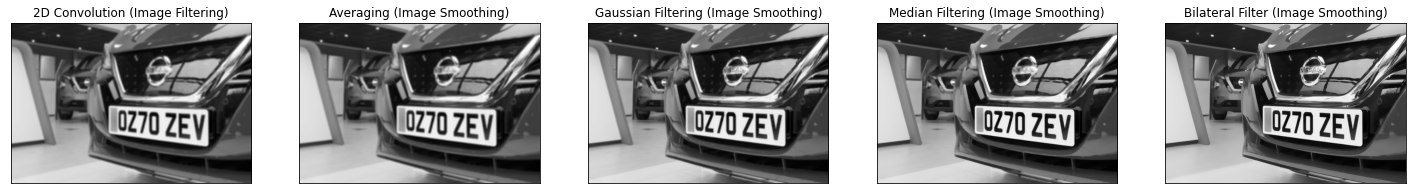

In [324]:
# Visualización de las 5 imágenes con blur, procesadas en el bloque de código anterior
plt.figure(figsize=(25,25))
plt.subplot(1,5,1),plt.imshow(cv2.cvtColor(blur2dConvGray , cv2.COLOR_BGR2RGB));plt.title('2D Convolution (Image Filtering)'), plt.xticks([]), plt.yticks([])
plt.subplot(1,5,2),plt.imshow(cv2.cvtColor(averagingBlurGray, cv2.COLOR_BGR2RGB));plt.title('Averaging (Image Smoothing)'), plt.xticks([]), plt.yticks([])
plt.subplot(1,5,3),plt.imshow(cv2.cvtColor(gaussianBlurGray , cv2.COLOR_BGR2RGB));plt.title("Gaussian Filtering (Image Smoothing)"), plt.xticks([]), plt.yticks([])
plt.subplot(1,5,4),plt.imshow(cv2.cvtColor(medianBlurGray , cv2.COLOR_BGR2RGB));plt.title("Median Filtering (Image Smoothing)"), plt.xticks([]), plt.yticks([])
plt.subplot(1,5,5),plt.imshow(cv2.cvtColor(bilateralBlurGray , cv2.COLOR_BGR2RGB));plt.title("Bilateral Filter (Image Smoothing)"), plt.xticks([]), plt.yticks([])
plt.show()



---


## PASO 2: DETECCIÓN DE BORDES (Procesamiento con aplicación de  filtros espaciales)
<p> Una vez que se ha difuminado la imagen original convertida a escala de grises, se pretende detectar los bordes que permanecen en la imagen. Para ello se han realizado tareas de prueba del método Canny y del filtro Gabor. Se ha escogido el método Canny por ser uno de los métodos vistos en clase y que mejores resultados ofrece. Se ha escogido el filtro Gabor como ejemplo de filtro espacial no visto en clase, analizado e implementado en la bibliografía (Program Talk, 2016)(Khan, 2016).
<p>Se han analizado ambos métodos en paralelo, para estudiar cual de ellos genera los mejores resultados. El criterio de selección del mejor de estos dos filtros viene determinado por las siguientes fases de resolución del problema, donde se analizan los contornos detectados.
<p>Tras realizar diferentes pruebas con el dataset creado y aplicando  variación en los valores de los parámetros se ha determinado que ambos métodos ofrecen resultados completamente diferentes, a priori no comparables entre sí. Los resultados de las siguientes fases son los que permiten establecer cual de estos métodos resuelve mejor la detección de la región de imagen de la matrícula.

In [325]:
# Definición de las funciones del Filtro Gabor
def build_filters(size):
 filters = []
 ksize = size
 for theta in np.arange(0, np.pi, np.pi / 16):
     gaborKernel = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
     gaborKernel /= 1.5*gaborKernel.sum()
     filters.append(gaborKernel)
 return filters
 
def process(img, filters):
 accum = np.zeros_like(img)
 for gaborKernel in filters:
     fimg = cv2.filter2D(img, cv2.CV_8UC3, gaborKernel)
     np.maximum(accum, fimg, accum)
 return accum

In [326]:
cannyEdges = cv2.Canny(blurredImage, 30, 200) # Aplicación del filtro Canny sobre la mejor de las imágenes difuminadas
gaborEdges = process(blurredImage, build_filters(17)) # Aplicación del filtro Gabor sobre la imagen difuminada, empleando las funciones definidas al principio de este script

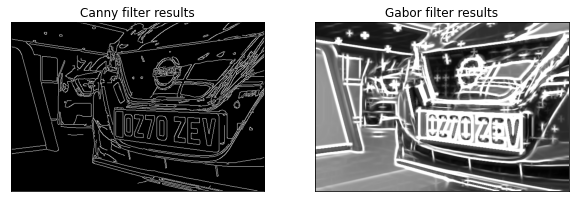

In [327]:
# Visualización de los resultados de la aplicación de los filtros de deteccion de bordes a la imagen en escala de grises
plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(cv2.cvtColor(cannyEdges, cv2.COLOR_BGR2RGB));plt.title("Canny filter results"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(cv2.cvtColor(gaborEdges, cv2.COLOR_BGR2RGB));plt.title("Gabor filter results"), plt.xticks([]), plt.yticks([])
plt.show()



---


## PASO 3: MEJORA DE LOS BORDES DETECTADOS (Aplicación de filtros morfológicos)
<P>Trar la realización de la batería de pruebas del paso 2 se ha detectado que los bordes de las imagenes resultantes presentan grosores muy dispares según el método empleado. El filtro Canny genera unos bordes extremadamente delgados y el filtro Gabor genera unos bordes muy anchos y con derivaciones. Por esto hemos decicido mejorar los bordes generados. Para ello se ha optado por aplicar dilatación al resultado que ofrece Canny y erosión al resultado que ofrece Gabor.

In [328]:
# Aplicación de filtro dilate sobre el resultado de Canny
kernel = np.ones((2,2),np.uint8)
cannyDilated = cv2.dilate(cannyEdges, kernel, iterations=1, borderType=cv2.BORDER_REFLECT)
 
# Aplicación de filtro Erosion sobre el resultado de Gabor
kernel = np.ones((5,5),np.uint8)
gaborEroded = cv2.erode(gaborEdges,kernel,iterations=1,borderType=cv2.BORDER_REFLECT)

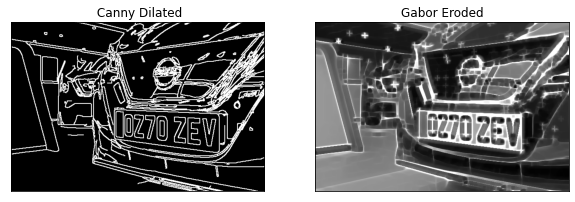

In [329]:
# Visualización de los resultados de la aplicación de los filtros morfológicos a las imágenes de bordes detectados
plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(cv2.cvtColor(cannyDilated, cv2.COLOR_BGR2RGB));plt.title(" Canny Dilated"),plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2),plt.imshow(cv2.cvtColor(gaborEroded, cv2.COLOR_BGR2RGB));plt.title("Gabor Eroded"),plt.xticks([]),plt.yticks([])
plt.show()



---


## PASO 4: DETECCION DE LA REGION DE LA MATRÍCULA
Una vez se han detectado y mejorado los bordes de la imagen, se pretende detectar la región del cuadrilátero que contiene a la matrícula. Para ello se han empleado las funciones openCv para la detección y pintado de contornos sobre las imagenes resultado del paso 3.

<p>Tras realizar baterías de pruebas con el resultado de Canny mejorado y con el resultado de Gabor mejorado se ha determinado que Canny es el que permite realizar la detección de la zona de la matrícula en un rango más amplio de escenarios y tipos de matrícula.

Se ha detectado la matrícula: -0Z70 ZEV



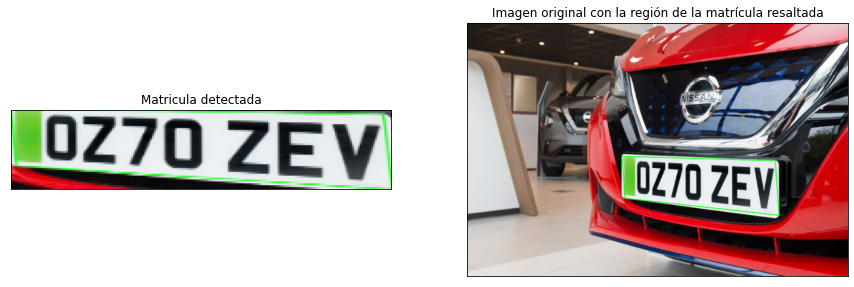

In [330]:
 # Detección de los contornos cerrados de la imagen de bordes
contornos = cv2.findContours(cannyDilated.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contornos = imutils.grab_contours(contornos)
contornos = sorted(contornos, key = cv2.contourArea, reverse = True)[:10] # Ordenación de los polígonos según numero descendente de vértices
cuadrilateroDectectado = None

for c in contornos:
  peri = cv2.arcLength(c, True)
  poligonosAproximados = cv2.approxPolyDP(c, 0.016 * peri, True)  
  if len(poligonosAproximados) == 4: # Selección del primer polígono de 4 vértices
    cuadrilateroDectectado = poligonosAproximados
    break

if cuadrilateroDectectado is None:
  print ("No se ha detectado ninguna matrícula")
else:
  cv2.drawContours(image, [cuadrilateroDectectado], -1, (0, 255, 0), thickness=1,lineType=cv2.LINE_AA)
  mascara = np.zeros(cannyDilated.shape,np.uint8)
  new_image = cv2.drawContours(mascara,[cuadrilateroDectectado],0,255,thickness=2,lineType=cv2.LINE_AA)
  new_image = cv2.bitwise_and(image,image,mask=mascara)

  # Detección de los puntos del rectangulo de la matricula pintados en verde
  (x, y) = np.where(mascara == 255)
  (topx, topy) = (np.min(x)+2, np.min(y)+2)
  (bottomx, bottomy) = (np.max(x)-2, np.max(y)-2)
  matricula = image[topx:bottomx+1, topy:bottomy+1]
  matricula = cv2.resize(matricula,(200,42))

  # Ejecución del reconocedor OCR a la region de la matricula y escritura del texto detectado, en caso de haberlo.
  print("Se ha detectado la matrícula: "+ pytesseract.image_to_string(cv2.cvtColor(matricula, cv2.COLOR_BGR2GRAY), config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))

  # Visualización de la región de la imagen que contiene a la matrícula y de la imagen original con la región de matrícula resaltada
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1),plt.imshow(cv2.cvtColor(matricula, cv2.COLOR_BGR2RGB));plt.title("Matricula detectada");plt.xticks([]),plt.yticks([])
  plt.subplot(1,2,2),plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));plt.title("Imagen original con la región de la matrícula resaltada");plt.xticks([]),plt.yticks([])
  plt.show()

---
## Resultados y conclusiones
<p>A partir de las pruebas obtenidas podemos indicar que la mejor solución encontrada para los pasos 1, 2 y 3 se define concatenando bilateralFilter + Canny + dilatación. Se han establecido unos parámetros de cada uno de los métodos empleados que permiten la detección regiones de matriculas en imagen de diferentes tamaños y colores. Se ha creado un dataset propio con imágenes de vehículos con diferentes ángulos y extraidas de internet. Se han estudiado, implementado y probado el método Canny y el filtro Gabor para la detección de bordes. La técnica Canny es la que mejores resultados ofrece para la detección de matrículas cuando se le añade una etapa de preprocesamiento basada en blur y una etapa de postprocesamiento basada en dilatación.
<p>La solución aportada compara opciones y establece un flujo de trabajo funcional para la de detección de matrículas. La solución puede ser aplicada en monitorización y control del flujo de tráfico, en control automático de acceso a recintos cerrados, o en identificación automática de vehículos infractores de normas viales.
<p> Como principales ventajas de esta implementación hay que destacar su alta velocidad de procesamiento, su simplicidad de código al estar implementada en Python, su alto grado de escalabilidad debido a su compatibilidad con PyWren para ser ejecutado en AWS LAmbda y sus diferentes opciones de aplicación.
<p> Como desventajas de la solución ofrecida hay que indicar que su funcionamiento se ve limitado a un conjunto determinado de entornos de fotografiado. Bajo ciertas condicione de iluminación y con aparición de ciertos objetos la solución debe ser reajustada manualmente. Además esta solución no es capaz de detectar placas falsas.


---
## Bibliografía

<div class=WordSection1>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Praveen</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>.
(7 julio 2020). <span class=SpellE><i>License</i></span><i> <span class=SpellE>Plate</span>
<span class=SpellE>Recognition</span> <span class=SpellE>using</span> <span
class=SpellE>OpenCV</span> Python</i>. Recuperado el 29 de enero de 2021, de <a
href="https://medium.com/programming-fever/license-plate-recognition-using-opencv-python-7611f85cdd6c">https://medium.com/programming-fever/license-plate-recognition-using-opencv-python-7611f85cdd6c</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Leung</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>,
K. (28 diciembre 2020). <span class=SpellE><i>Russian</i></span><i> Car <span
class=SpellE>Plate</span> <span class=SpellE>Detection</span> <span
class=SpellE>with</span> <span class=SpellE>OpenCV</span> and <span
class=SpellE>TesseractOCR</span>. Medium</i>. Recuperado el 29 de enero de 2021,
de <a
href="https://towardsdatascience.com/russian-car-plate-detection-with-opencv-and-tesseractocr-dce3d3f9ff5c">https://towardsdatascience.com/russian-car-plate-detection-with-opencv-and-tesseractocr-dce3d3f9ff5c</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span style='font-size:10.0pt;
font-family:"Calibri",sans-serif;mso-ascii-theme-font:minor-latin;mso-hansi-theme-font:
minor-latin;mso-bidi-theme-font:minor-latin'>Solano, G. (9 marzo 2020). <i>Reconocimiento
de matrículas vehiculares | <span class=SpellE>OpenCV</span>, <span
class=SpellE>Pytesseract</span> (OCR) – Python</i>. <span class=SpellE>omes</span>-va.
Recuperado el 30 enero de 2021, de <a
href="https://omes-va.com/reconocimiento-de-matriculas-vehiculares-opencv-pytesseract-ocr-python/">https://omes-va.com/reconocimiento-de-matriculas-vehiculares-opencv-pytesseract-ocr-python/</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span style='font-size:10.0pt;
font-family:"Calibri",sans-serif;mso-ascii-theme-font:minor-latin;mso-hansi-theme-font:
minor-latin;mso-bidi-theme-font:minor-latin'>Dan (12 marzo 2019). <i>Edge <span
class=SpellE>Detection</span> in <span class=SpellE>Opencv</span> 4.0, A 15
Minutes Tutorial</i>. <span class=SpellE>Sicara</span>. Recuperado el 27 enero
de 2021, de <a
href="https://www.sicara.ai/blog/2019-03-12-edge-detection-in-opencv">https://www.sicara.ai/blog/2019-03-12-edge-detection-in-opencv</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>OpenCV</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>
(2020). <span class=SpellE><i>Smoothing</i></span><i> <span class=SpellE>images</span></i>.
<span class=SpellE><span class=GramE>docs.opencv</span></span>. Recuperado el 1
febrero 2021 de <a
href="https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html">https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>TecniTran</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>
Telecomunicaciones (2019). <i>ANPR Reconocimiento de Matrículas</i>. Recuperado
el 28 enero de 2021, de <a
href="https://www.tecnitran.es/anpr-reconocimiento-de-matriculas/">https://www.tecnitran.es/anpr-reconocimiento-de-matriculas/</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Karthikeyan</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>,
V., &amp; <span class=SpellE>Vijayalakshmi</span>, V. J. (2014). <span
class=SpellE><i>Localization</i></span><i> <span class=SpellE>of</span> <span
class=SpellE>License</span> <span class=SpellE>Plate</span> <span class=SpellE>Using</span>
<span class=SpellE>Morphological</span> <span class=SpellE>Operations</span></i>.
ArXiv.Org. <a href="https://arxiv.org/abs/1402.5623">https://arxiv.org/abs/1402.5623</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span style='font-size:10.0pt;
font-family:"Calibri",sans-serif;mso-ascii-theme-font:minor-latin;mso-hansi-theme-font:
minor-latin;mso-bidi-theme-font:minor-latin'>Khan, M. F., &amp; <span
class=SpellE>Mufti</span>, N. (2016)<i>. <span class=SpellE>Comparison</span> <span
class=SpellE>of</span> <span class=SpellE>various</span> <span class=SpellE>edge</span>
<span class=SpellE>detection</span> <span class=SpellE>filters</span> <span
class=SpellE>for</span> ANPR</i>. En 2016 <span class=SpellE>Sixth</span>
International <span class=SpellE>Conference</span> <span class=SpellE>on</span>
<span class=SpellE>Innovative</span> Computing <span class=SpellE>Technology</span>
(INTECH) (pp. 306-309). IEEE.<o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Liang</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>,
J. (2021). <span class=SpellE><i>Canny</i></span><i> Edge <span class=SpellE>Detection</span>.
</i><span class=SpellE>justin-liang</span>. Recuperado el 26 enero de 2021, de <a
href="http://justin-liang.com/tutorials/canny/">http://justin-liang.com/tutorials/canny/</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span style='font-size:10.0pt;
font-family:"Calibri",sans-serif;mso-ascii-theme-font:minor-latin;mso-hansi-theme-font:
minor-latin;mso-bidi-theme-font:minor-latin'>James, S. (8 abril 2020). <i>Edge <span
class=SpellE>Detection</span> <span class=SpellE>Techniques</span> - <span
class=SpellE>Image</span> Processing <span class=SpellE>with</span> <span
class=SpellE>OpenCV</span>.</i> <span class=SpellE>Hubofco</span>. Recuperado el
30 enero de 2021, de <a
href="https://hubofco.de/machinelearning/2020/04/08/Egde-detection-in-open-cv/">https://hubofco.de/machinelearning/2020/04/08/Egde-detection-in-open-cv/</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Tak</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>,
T. (2021). <i>cv2.CV_32F</i>. <span class=SpellE>Programtalk</span>. Recuperado
el 31 de enero de 2021, de <a
href="https://programtalk.com/python-examples/cv2.CV_32F/">https://programtalk.com/python-examples/cv2.CV_32F/</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Obedeir</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'> (2019).
<i>Small <span class=SpellE>python</span> <span class=SpellE>code</span> <span
class=SpellE>for</span> <span class=SpellE>building</span> Gabor <span
class=SpellE>filters</span></i>. <span class=SpellE>Github</span>. Recuperado el
31 enero de 2021, de <a href="https://gist.github.com/odebeir/5237529">https://gist.github.com/odebeir/5237529</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span style='font-size:10.0pt;
font-family:"Calibri",sans-serif;mso-ascii-theme-font:minor-latin;mso-hansi-theme-font:
minor-latin;mso-bidi-theme-font:minor-latin'>Ruiz Fernández, L. Á. (2020). <i>Aplicación
de filtros morfológicos en imágenes</i>. Ingeniería Cartográfica, Geodesia y Fotogrametría
– <span class=SpellE>Universitat</span> <span class=SpellE>Politecnica</span>
de Valencia<o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Savani</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>,
B. (22 marzo 2019). <i>OCR <span class=SpellE>from</span> <span class=SpellE>Image</span>
<span class=SpellE>using</span> <span class=SpellE>PyTesseract</span> in Python
<span class=SpellE>on</span> <span class=SpellE>Colab</span> Notebook?</i>
Medium. Recuperado el 30 enero de 2021, de <a
href="https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0">https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0</a><o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Vegi</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>,
L. K., &amp; <span class=SpellE>Vegi</span>, V. G. (2013). <span class=SpellE><i>Design</i></span><i>
and <span class=SpellE>analysis</span> <span class=SpellE>of</span> <span
class=SpellE>connecting</span> <span class=SpellE>rod</span> <span
class=SpellE>using</span> <span class=SpellE>forged</span> <span class=SpellE>steel</span></i>.
International <span class=SpellE>Journal</span> <span class=SpellE>of</span> <span
class=SpellE>Scientific</span> &amp; <span class=SpellE>Engineering</span> <span
class=SpellE>Research</span>, 4(6).<o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Yepez</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>,
J., &amp; <span class=SpellE>Ko</span>, S. B. (2018). <span class=SpellE><i>Improved</i></span><i>
<span class=SpellE>license</span> <span class=SpellE>plate</span> <span
class=SpellE>localisation</span> <span class=SpellE>algorithm</span> <span
class=SpellE>based</span> <span class=SpellE>on</span> <span class=SpellE>morphological</span>
<span class=SpellE>operations</span></i>. IET <span class=SpellE>Intelligent</span>
<span class=SpellE>Transport</span> <span class=SpellE>Systems</span>, 12(6),
542-549.<o:p></o:p></span></p>

<p style='margin-left:1.0cm;text-indent:-1.0cm'><span class=SpellE><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>Zhai</span></span><span
style='font-size:10.0pt;font-family:"Calibri",sans-serif;mso-ascii-theme-font:
minor-latin;mso-hansi-theme-font:minor-latin;mso-bidi-theme-font:minor-latin'>,
X., <span class=SpellE>Benssali</span>, F., &amp; <span class=SpellE>Ramalingam</span>,
S. (2010, <span class=SpellE>December</span>). <span class=SpellE><i>License</i></span><i>
<span class=SpellE>plate</span> <span class=SpellE>localisation</span> <span
class=SpellE>based</span> <span class=SpellE>on</span> <span class=SpellE>morphological</span>
<span class=SpellE>operations</span></i>. In 2010 11th International <span
class=SpellE>Conference</span> <span class=SpellE>on</span> Control <span
class=SpellE>Automation</span> <span class=SpellE>Robotics</span> &amp; <span
class=SpellE>Vision</span> (pp. 1128-1132). IEEE.<o:p></o:p></span></p>


</div>

| | |
|:------|:------|
| Todos los miembros se han integrado al trabajo del grupo | Sí |
| Todos los miembros respetan otras ideas aportadas | Sí |
| Todos los miembros participan en la elaboración del informe | Sí |
| Me he preocupado por realizar un trabajo cooperativo con mis compañeros | Sí |
| Señala si consideras que algún aspecto del trabajo en grupo no ha sido adecuado | |